In [1]:

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F

from AgeDatasetLoader import AgeDataset

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print_every = 100

print('using device:', device)

using device: cuda


In [3]:
age_train = AgeDataset("age_data/age-train.csv")
loader_train = DataLoader(age_train, batch_size=32, shuffle=True, num_workers=2)

age_val = AgeDataset("age_data/age-val.csv")
loader_val = DataLoader(age_val, batch_size=32, shuffle=True, num_workers=2)


age_test = AgeDataset("age_data/age-test.csv")
loader_test = DataLoader(age_test, batch_size=32, shuffle=True, num_workers=2)



In [4]:
def check_accuracy(loader, model):
    print("iniating check acc func")
    print("checking accuracy of dataset")  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [5]:


def train(model, optimizer, epochs=1):

    print("iniating train func")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            
            
        
          #  print(scores.size())
          #  print(x.size(), y.size())
            loss = F.cross_entropy(scores, y)
            

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
      
            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy(loader_val, model)
                print()
    return check_accuracy(loader_val, model)

In [6]:

class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleNeck, self).__init__()
        self.in_channels = in_channels
        self.conv1_1 = nn.Conv2d(self.in_channels, 4*growth_rate, kernel_size=1, stride=1)
        self.bn1_1 = nn.BatchNorm2d(4*growth_rate)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(growth_rate)
        self.relu1_2 = nn.ReLU(inplace=True)

    def forward(self,x):
        xin = x
       # print(self.in_channels)
        x = self.conv1_1(x)
        x = self.bn1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
      #  x = self.bn1_2(x)
        x = self.relu1_2(x)
        x = torch.cat([xin,x],1)

        return x







#first dense block, 6 bottleneck layers
#trans layer
#second dense block, 12 bottleneck layers
# trans layer
#third dense block, 24 bottleneck layers
# trans layer
#last dense block, 16 bottleneck layers 
# no trans layer in last
# need to add global average pooling layer 



In [7]:
class DenseBlock(nn.Module):
    def __init__(self, in_channel,layer_num, growth_rate):
        super(DenseBlock, self).__init__()
        self.layer_num = layer_num
        self.in_channel = in_channel
        self.k = growth_rate
        self.deep_nn = nn.ModuleList()
        for num in range(self.layer_num):
          #  print("Layer num ", num)
            #print(self.in_channel+self.k*self.layer_num)
            self.deep_nn.add_module(f"BottleNeckLayer_{num}",BottleNeck(self.in_channel+self.k*num, self.k))
        
    def forward(self,x):
        i = 0
        for layer in self.deep_nn:
            #print(i)
            #print(x.size())
            x = layer(x)
            i = i+1
              
        return x


In [8]:


class Transition(nn.Module):
    def __init__(self, in_channels, compression_factor):
        super(Transition, self).__init__()
        self.compression_factor = compression_factor
        self.in_channels = in_channels
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, int(self.in_channels*self.compression_factor), kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d((2,2))

    def forward(self,x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)

        return x



In [9]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate, compression_factor):
        super(DenseNet, self).__init__()
        self.k = growth_rate
        self.compression = compression_factor
        self.input_channels = [1,1+self.k*6, int((1+self.k*6)*self.compression), int((1+self.k*6)*self.compression) + 12*self.k , int((int((1+self.k*6)*self.compression) + 12*self.k)*self.compression),
                               int((int((1+self.k*6)*self.compression) + 12*self.k)*self.compression) + 24*self.k,  int((int((int((1+self.k*6)*self.compression) + 12*self.k)*self.compression) + 24*self.k)*self.compression) ]

        #print("set denseBlock1")
       
        self.denseBlock1 = DenseBlock(self.input_channels[0],6,self.k)
        self.transition1 = Transition(self.input_channels[1], self.compression)
        #print("set denseBlock2")
        self.denseBlock2 = DenseBlock(self.input_channels[2],12,self.k)
        self.transition2 = Transition(self.input_channels[3], self.compression)
        #print("set denseBlock3")
        self.denseBlock3 = DenseBlock(self.input_channels[4], 24,self.k)
        self.transition3 = Transition(self.input_channels[5], self.compression)
        #print("set denseBlock4")
        self.denseBlock4 = DenseBlock(self.input_channels[6],16,self.k)

        self.fc1 = nn.Linear(int(4064*(self.k/32)), 512)
        self.fc2 = nn.Linear(512, 24)
        self.fc3 = nn.Linear(24, 24)  
        self.avgpool = nn.AdaptiveAvgPool2d((2,2))
        self.dropout = nn.Dropout(0.5)


    def forward(self,x):

       # print("denseBlock1")
         x = self.denseBlock1(x)
        # print("transition1")
         x = self.transition1(x)
        # print("denseBlock1")
         x = self.denseBlock2(x)
        # print("denseBlock1")
         x = self.transition2(x)
        # print("denseBlock1")
         x = self.denseBlock3(x)
         x = self.transition3(x)
         x = self.denseBlock4(x)
         x = x.view(x.size(0), -1)
         x = self.fc1(x)
         x = self.fc2(x)
         x = self.fc3(x)          

         return x

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            

In [20]:
#getting better results

model = DenseNet(16,0.5);
model.apply(weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print_every = 500
train(model, optimizer, epochs=10)
print_every = 100

iniating train func
Epoch 0, Iteration 500, loss = 2.2303
iniating check acc func
checking accuracy of dataset
Got 855 / 3556 correct (24.04)

Epoch 1, Iteration 500, loss = 2.2670
iniating check acc func
checking accuracy of dataset
Got 398 / 3556 correct (11.19)

Epoch 2, Iteration 500, loss = 2.6661
iniating check acc func
checking accuracy of dataset
Got 893 / 3556 correct (25.11)

Epoch 3, Iteration 500, loss = 1.8921
iniating check acc func
checking accuracy of dataset
Got 1081 / 3556 correct (30.40)

Epoch 4, Iteration 500, loss = 2.1568
iniating check acc func
checking accuracy of dataset
Got 1047 / 3556 correct (29.44)

Epoch 5, Iteration 500, loss = 2.2151
iniating check acc func
checking accuracy of dataset
Got 1094 / 3556 correct (30.76)

Epoch 6, Iteration 500, loss = 2.1653
iniating check acc func
checking accuracy of dataset
Got 1117 / 3556 correct (31.41)

Epoch 7, Iteration 500, loss = 1.9977
iniating check acc func
checking accuracy of dataset
Got 755 / 3556 correct (

In [60]:
model = DenseNet(32,0.5);
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print_every = 500
train(model, optimizer, epochs=10)
print_every = 100

iniating train func
Epoch 0, Iteration 500, loss = 2.3944
iniating check acc func
checking accuracy of dataset
Got 774 / 3556 correct (21.77)

Epoch 1, Iteration 500, loss = 2.3318
iniating check acc func
checking accuracy of dataset
Got 1046 / 3556 correct (29.42)

Epoch 2, Iteration 500, loss = 2.3777
iniating check acc func
checking accuracy of dataset
Got 1086 / 3556 correct (30.54)

Epoch 3, Iteration 500, loss = 1.6440
iniating check acc func
checking accuracy of dataset
Got 1144 / 3556 correct (32.17)

Epoch 4, Iteration 500, loss = 1.8041
iniating check acc func
checking accuracy of dataset
Got 1114 / 3556 correct (31.33)

Epoch 5, Iteration 500, loss = 1.8808
iniating check acc func
checking accuracy of dataset
Got 1113 / 3556 correct (31.30)

Epoch 6, Iteration 500, loss = 1.9883
iniating check acc func
checking accuracy of dataset
Got 1221 / 3556 correct (34.34)

Epoch 7, Iteration 500, loss = 1.8495
iniating check acc func
checking accuracy of dataset
Got 1169 / 3556 correc

In [19]:
model = DenseNet(8,0.5);
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print_every = 500
train(model, optimizer, epochs=10)
print_every = 100

iniating train func
Epoch 0, Iteration 500, loss = 2.1542
iniating check acc func
checking accuracy of dataset
Got 882 / 3556 correct (24.80)

Epoch 1, Iteration 500, loss = 2.1759
iniating check acc func
checking accuracy of dataset
Got 994 / 3556 correct (27.95)

Epoch 2, Iteration 500, loss = 2.2958
iniating check acc func
checking accuracy of dataset
Got 1042 / 3556 correct (29.30)

Epoch 3, Iteration 500, loss = 1.7932
iniating check acc func
checking accuracy of dataset
Got 1089 / 3556 correct (30.62)

Epoch 4, Iteration 500, loss = 1.8418
iniating check acc func
checking accuracy of dataset
Got 948 / 3556 correct (26.66)

Epoch 5, Iteration 500, loss = 2.0173
iniating check acc func
checking accuracy of dataset
Got 1138 / 3556 correct (32.00)

Epoch 6, Iteration 500, loss = 1.8248
iniating check acc func
checking accuracy of dataset
Got 1150 / 3556 correct (32.34)

Epoch 7, Iteration 500, loss = 1.6908
iniating check acc func
checking accuracy of dataset
Got 1140 / 3556 correct 

In [10]:
#Tuning learning rate

accuracy_values = []
lr_values = []

for i in range(1,7):
    model = DenseNet(16,0.5);
    lr_hp = 10 ** (-1*i)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_hp)
   
    print_every = 5000
    acc = train(model, optimizer, epochs=10)
    print("lr ",lr_hp,"acc ", acc)
    accuracy_values.append(acc)
    lr_values.append(lr_hp)


iniating train func
iniating check acc func
checking accuracy of dataset
Got 772 / 3556 correct (21.71)
lr  0.1 acc  0.2170978627671541
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1147 / 3556 correct (32.26)
lr  0.01 acc  0.32255343082114735
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1162 / 3556 correct (32.68)
lr  0.001 acc  0.32677165354330706
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1131 / 3556 correct (31.81)
lr  0.0001 acc  0.31805399325084366
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1024 / 3556 correct (28.80)
lr  1e-05 acc  0.2879640044994376
iniating train func
iniating check acc func
checking accuracy of dataset
Got 889 / 3556 correct (25.00)
lr  1e-06 acc  0.25


In [ ]:
#The optimal value of learning rate was found to be 0.001

In [12]:
#tuning weight_decay
accuracy_values = []
wd_values = []

for i in range(1,7):
    model = DenseNet(16,0.5);
    wd_hp = 10 ** (-1*i)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = wd_hp)
   
    print_every = 5000
    acc = train(model, optimizer, epochs=10)
    print("weight_decay ",wd_hp,"acc ", acc)
    accuracy_values.append(acc)
    wd_values.append(wd_hp)

iniating train func
iniating check acc func
checking accuracy of dataset
Got 765 / 3556 correct (21.51)
weight_decay  0.1 acc  0.21512935883014622
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1013 / 3556 correct (28.49)
weight_decay  0.01 acc  0.2848706411698538
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1077 / 3556 correct (30.29)
weight_decay  0.001 acc  0.30286839145106864
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1229 / 3556 correct (34.56)
weight_decay  0.0001 acc  0.3456130483689539
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1255 / 3556 correct (35.29)
weight_decay  1e-05 acc  0.35292463442069744
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1173 / 3556 correct (32.99)
weight_decay  1e-06 acc  0.3298650168728909


In [13]:
#Tuning epochs
accuracy_values = []
epoch_values = []

for i in range(10,100,20):
    model = DenseNet(16,0.5);
  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.000001)
   
    print_every = 5000
    acc = train(model, optimizer, epochs=i)
    print("epoch",i,"acc", acc)
    accuracy_values.append(acc)
    epoch_values.append(i)

iniating train func
iniating check acc func
checking accuracy of dataset
Got 1224 / 3556 correct (34.42)
epoch 10 acc 0.344206974128234
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1119 / 3556 correct (31.47)
epoch 30 acc 0.31467941507311586
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1085 / 3556 correct (30.51)
epoch 50 acc 0.3051181102362205
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1120 / 3556 correct (31.50)
epoch 70 acc 0.31496062992125984
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1109 / 3556 correct (31.19)
epoch 90 acc 0.311867266591676


In [11]:
def check_accuracy(loader, model, device = 'cuda', dtype=torch.float32):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            
            loss = F.cross_entropy(scores, y, reduction='sum')
            total_loss += loss.item()
            
            _, preds = scores.max(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [12]:
import matplotlib.pyplot as plt
def train(model, optimizer, loader_train, loader_val, epochs=1, device='cuda', dtype=torch.float32):
    model = model.to(device=device)

    train_epochs = []
    train_losses = []
    train_accuracies = []
    
    val_epochs = []
    val_losses = []
    val_accuracies = []

    num_batches_per_epoch = len(loader_train)  
    half_epoch_interval = num_batches_per_epoch // 2  

    iteration = 0  

    for epoch in range(epochs):
        model.train()
        for batch_idx, (x, y) in enumerate(loader_train):
            iteration += 1

            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = scores.max(dim=1)
            batch_acc = (preds == y).float().mean().item()

            if (batch_idx + 1) % half_epoch_interval == 0:
                epoch_progress = epoch + (batch_idx + 1) / num_batches_per_epoch 
                
                val_loss, val_acc = check_accuracy(loader_val, model, device, dtype)

                train_epochs.append(epoch_progress)
                train_losses.append(loss.item())
                train_accuracies.append(batch_acc)

                val_epochs.append(epoch_progress)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

                print(f"Epoch [{epoch_progress:.1f}/{epochs}], "
                      f"Train Loss: {loss.item():.4f}, Train Acc: {batch_acc*100:.2f}% "
                      f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    final_val_loss, final_val_acc = check_accuracy(loader_val, model, device, dtype)
    print(f"Finished training. Final val loss = {final_val_loss:.4f}, val acc = {final_val_acc*100:.2f}%")

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_epochs, train_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1,2,2)
    plt.plot(train_epochs, train_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(val_epochs, val_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')

    plt.subplot(1,2,2)
    plt.plot(val_epochs, val_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()
    return final_val_loss, final_val_acc


Epoch [0.5/10], Train Loss: 2.8539, Train Acc: 21.88% | Val Loss: 2.6939, Val Acc: 21.26%
Epoch [1.0/10], Train Loss: 2.3703, Train Acc: 18.75% | Val Loss: 2.4489, Val Acc: 21.23%
Epoch [1.5/10], Train Loss: 2.2290, Train Acc: 43.75% | Val Loss: 2.2982, Val Acc: 27.67%
Epoch [2.0/10], Train Loss: 2.3804, Train Acc: 18.75% | Val Loss: 2.2115, Val Acc: 28.29%
Epoch [2.5/10], Train Loss: 2.3350, Train Acc: 15.62% | Val Loss: 2.4037, Val Acc: 24.27%
Epoch [3.0/10], Train Loss: 2.3681, Train Acc: 18.75% | Val Loss: 2.0900, Val Acc: 30.26%
Epoch [3.5/10], Train Loss: 1.9471, Train Acc: 34.38% | Val Loss: 2.0721, Val Acc: 30.99%
Epoch [4.0/10], Train Loss: 2.0871, Train Acc: 25.00% | Val Loss: 2.0515, Val Acc: 31.41%
Epoch [4.5/10], Train Loss: 2.0415, Train Acc: 28.12% | Val Loss: 2.0070, Val Acc: 31.58%
Epoch [5.0/10], Train Loss: 2.2170, Train Acc: 25.00% | Val Loss: 2.1486, Val Acc: 30.09%
Epoch [5.5/10], Train Loss: 1.9388, Train Acc: 28.12% | Val Loss: 1.9559, Val Acc: 32.82%
Epoch [6.0

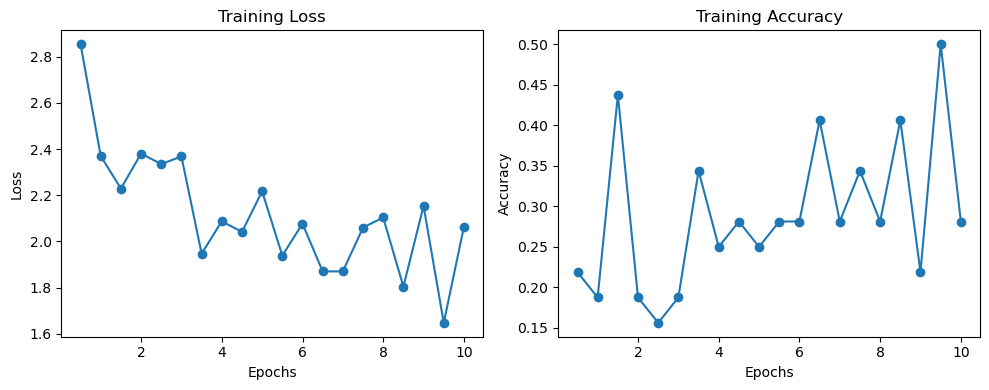

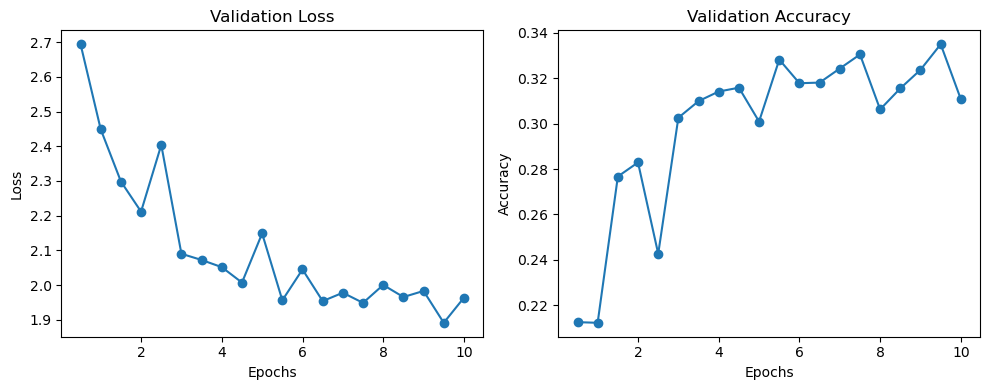

In [13]:


model = DenseNet(16,0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

final_accuracy = train(model, optimizer, loader_train, loader_val, epochs=10)

In [14]:

test_loss, test_acc = check_accuracy(loader_test, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 1.9184, Test Accuracy: 32.85%


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def create_heatmap(loader, model, device='cuda', dtype=torch.float32):
  

    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    y_pred = []  # Store predictions
    y_true = []  # Store actual labels

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y, reduction='sum')
            total_loss += loss.item()

            _, preds = scores.max(dim=1)  # Get predicted class labels
            y_pred.extend(preds.cpu().numpy())  # Convert to list and store
            y_true.extend(y.cpu().numpy())  # Store actual labels

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29",
                   "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",
                   "60-64", "65-69", "70-74", "75-79", "80-84", "85-89",
                   "90-94", "95-99", "100-104", "105-109", "110-114", "115-119"]
    plt.figure(figsize=(10,9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("VGG-16 Model Heatmap")
    plt.show()
    return None
    


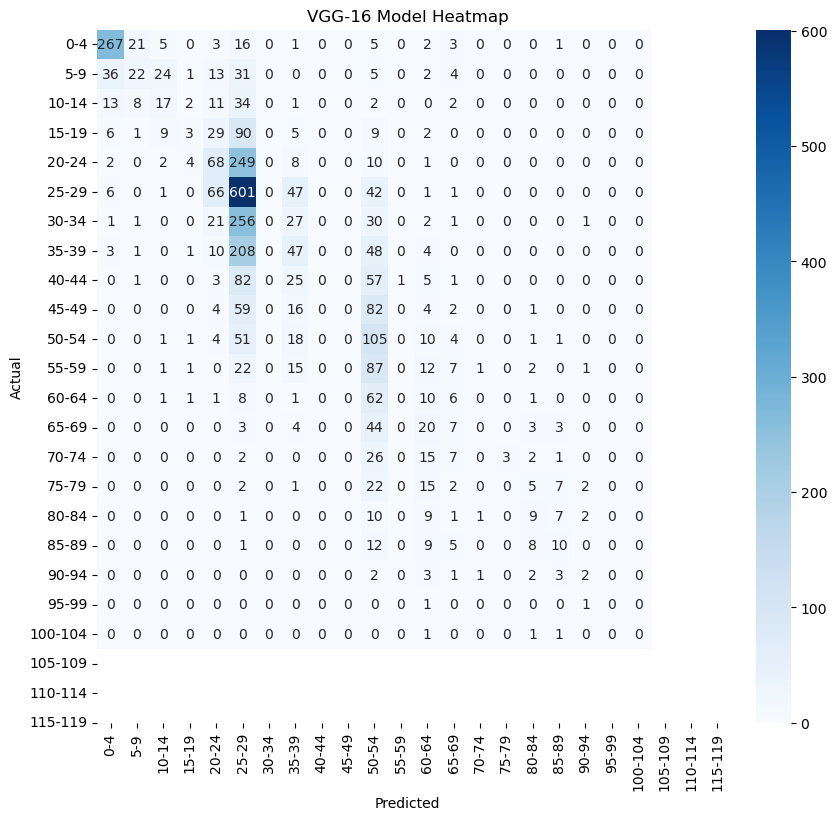

In [26]:
create_heatmap(loader_test, model)